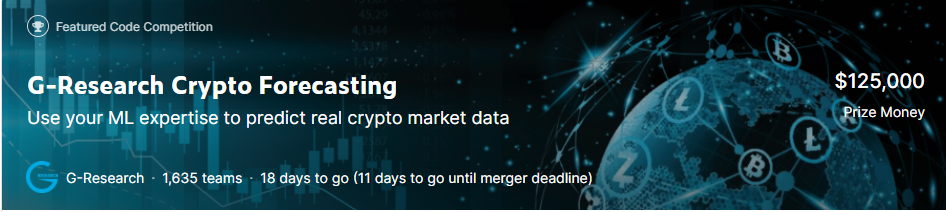

### 全Coinに何らかの関係があると前提をおいたNotebook。

### Notebook that assumes that all Coins have something to do with it.

February 1, 2022 - Final submission deadline.

In [ ]:
import os
import random
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import lightgbm as lgb
import gresearch_crypto
import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error as MSE
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

TRAIN_CSV = '/kaggle/input/g-research-crypto-forecasting/train.csv'
ASSET_DETAILS_CSV = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

SEED = 2021

REMOVE_LB_TEST_OVERLAPPING_DATA = True

In [ ]:
'''
!cp ../input/talibinstall/ta-lib-0.4.0-src.tar.gzh  ./ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz > null
!cd ta-lib && ./configure --prefix=/usr > null && make  > null && make install > null
!cp ../input/talibinstall/TA-Lib-0.4.21.tar.gzh TA-Lib-0.4.21.tar.gz
!pip install TA-Lib-0.4.21.tar.gz > null
!pip install ../input/talibinstall/numpy-1.21.4-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl >null
import talib as ta
'''

In [ ]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

fix_all_seeds(SEED)

# Data Load

In [ ]:
df_train = pd.read_csv(TRAIN_CSV)
df_train = df_train.dropna(subset=['Target']).reset_index(drop=True)

In [ ]:
df_test = pd.read_csv('../input/g-research-crypto-forecasting/example_test.csv')
df_test.head()

In [ ]:
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")
df_asset_details

### データを直近のものだけにする

### Keep data only recent

In [ ]:

l =len(df_train)
l = l//3
df_train = df_train[l:].reset_index(drop=True)
df_train



## Keep only values _before_ the LB test set

In [ ]:
# Remove the future
if REMOVE_LB_TEST_OVERLAPPING_DATA:
    df_train['datetime'] = pd.to_datetime(df_train['timestamp'], unit='s')
    df_valid = df_train[(df_train['datetime'] > '2021-06-13 00:00:00')].reset_index(drop=True)
    df_train = df_train[(df_train['datetime'] < '2021-06-13 00:00:00')].reset_index(drop=True)
    df_train  = df_train.drop(['datetime'],axis=1)
    df_valid  = df_valid.drop(['datetime'],axis=1)
else:
    df_train['datetime'] = pd.to_datetime(df_train['timestamp'], unit='s')
    df_valid = df_train[(df_train['datetime'] > '2021-06-13 00:00:00')].reset_index(drop=True)
    df_train  = df_train.drop(['datetime'],axis=1)
    df_valid  = df_valid.drop(['datetime'],axis=1)


In [ ]:
df_valid = df_valid.dropna(subset=['Target']).reset_index(drop=True)
df_valid

# 行列の標準化

# Matrix standardization

In [ ]:
#%%capture
#'''
df_train = df_train.fillna(-1)
df_train.VWAP = df_train.VWAP.replace(np.inf,0)
df_train.VWAP = df_train.VWAP.replace(-np.inf,0)

df_valid = df_valid.fillna(-1)
df_valid.VWAP = df_valid.VWAP.replace(np.inf,0)
df_valid.VWAP = df_valid.VWAP.replace(-np.inf,0)

dfs = df_train.iloc[:, 2:-1].apply(lambda x: (x-x.mean())/x.std(), axis=0)
df_train.iloc[:, 2:-1] = dfs 

dfs = df_valid.iloc[:, 2:-1].apply(lambda x: (x-x.mean())/x.std(), axis=0)
df_valid.iloc[:, 2:-1] = dfs 
#'''

In [ ]:
#asset_weight_dict =df_asset_details[['Asset_ID','Weight']].to_dict()
#df_train['Weight'] = df_train['Asset_ID'].map(asset_weight_dict['Weight'])/10 意味がない
#df_valid['Weight'] = df_valid['Asset_ID'].map(asset_weight_dict['Weight'])/10
#df_train

In [ ]:
df_valid

# Data Merge

In [ ]:
train = pd.DataFrame(index=(df_train['timestamp'].unique()))
train['timestamp'] = df_train['timestamp'].unique()
for i in range(len((df_train.Asset_ID.unique()))):
    data = df_train[df_train.Asset_ID == i].copy()
    for x in data.columns:
        if x !='timestamp':
            if x == 'Asset_ID':
                continue 
            else:
                
                    train[f"{x}_{i}"]  = data[f"{x}"] 
        else:
            data.set_index("timestamp",inplace=True)  

In [ ]:
del df_train
train

In [ ]:

valid = pd.DataFrame(index=(df_valid['timestamp'].unique()))
valid['timestamp'] = df_valid['timestamp'].unique()
for i in range(len((df_valid.Asset_ID.unique()))):
    data = df_valid[df_valid.Asset_ID == i].copy()
    for x in data.columns:
        if x !='timestamp':
            if x == 'Asset_ID':
                continue #train[f"{x}_{i}"]  = data[f"{x}"].astype(int)
            else:
               
                valid[f"{x}_{i}"]  = data[f"{x}"] 
        else:
            data.set_index("timestamp",inplace=True)  
            
del df_valid

In [ ]:
valid

## `学習データの非連続化

## `Discontinuity of training data

In [ ]:
#train = train.sample(n=len(train), random_state=0)
valid = valid.sample(n=len(valid), random_state=0)

In [ ]:
test = pd.DataFrame(index=(df_test['timestamp'].unique()))
for i in range(14):
    data = df_test[df_test.Asset_ID == i].copy()
    for x in data.columns:
        if x !='timestamp':
            if x == 'Asset_ID':
                continue #test[f"{x}_{i}"]  = data[f"{x}"].astype(int)
            else:
                if x!='group_num' and x!='row_id':
                    test[f"{x}_{i}"]  = data[f"{x}"] 
        else:
            data.set_index("timestamp",inplace=True)  

In [ ]:
test

# Function

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
#!pip install optuna
import optuna 
import optuna.integration.lightgbm as lgbo

In [ ]:
def hlco_ratio(df): 
    return (df['High'] - df['Low'])/(df['Close']-df['Open'])
def upper_shadow(df):
    return
def lower_shadow(df):
    return

In [ ]:
def get_features(df):
    
    times = pd.to_datetime(df.index,unit="s",infer_datetime_format=True)
    df["hour"] = times.hour  
    df["dayofweek"] = times.dayofweek 
    df["day"] = times.day 
    for i in range(14):
        df[f'Upper_Shadow_{i}'] =  df[f'High_{i}'] - np.maximum(df[f'Close_{i}'], df[f'Open_{i}'])
        df[f'hlco_ratio_{i}'] =  (df[f'High_{i}'] - df[f'Low_{i}'])/(df[f'Close_{i}']-df[f'Open_{i}'])
        df[f'Lower_Shadow_{i}'] =  np.minimum(df[f'Close_{i}'], df[f'Open_{i}']) - df[f'Low_{i}']
        df[f'diff_upper{i}'] =df[f'Upper_Shadow_{i}'].diff().fillna(0)
        df[f'diff_ratio_{i}'] =df[f'hlco_ratio_{i}'].diff().fillna(0)
        df[f'diff_Shadow_{i}'] = df[f'Lower_Shadow_{i}'].diff().fillna(0)
        
        df[f'open2close_{i}'] = df[f'Close_{i}'] / df[f'Open_{i}']
        df[f'high2low_{i}'] = df[f'High_{i}'] / df[f'Low_{i}']
        
        #mean_price = df[[f'Open_{i}', f'High_{i}', f'Low_{i}', f'Close_{i}']].mean(axis=1)
        #median_price = df[[f'Open_{i}', f'High_{i}', f'Low_{i}', f'Close_{i}']].median(axis=1)
        #df[f'high2mean_{i}'] = df[f'High_{i}'] / mean_price
        #df[f'low2mean_{i}'] = df[f'Low_{i}'] / mean_price
        #df[f'high2median_{i}'] = df[f'High_{i}'] / median_price
        #df[f'low2median_{i}'] = df[f'Low_{i}'] / median_price
        #df[f'volume2count_{i}'] = df[f'Volume_{i}'] / (df[f'Count_{i}'] + 1)
    
        ##df[f"high_div_low_{i}"] = df[f"High_{i}"] / df[f"Low_{i}"]
        #df[f"open_sub_close_{i}"] = df[f"Open_{i}"] - df[f"Close_{i}"]
    return df 

# Train 

In [ ]:
    models={}
    train = get_features(train)
    valid = get_features(valid)
    #train = df_proc.fillna(-1)
    #train = train.drop(['Asset_ID','Target'],axis=1)
    for i in range(14): 
        X = train.copy() #[train.Asset_ID==i].reset_index(drop=True)
        
        X = X.dropna(subset=[f"Target_{i}"])
        y = X[f"Target_{i}"]
        #y= np.log1p(y)
        
        for x in range(14): 
            X = X.drop([f'Target_{x}'],axis=1)
            
        print(f'Asset_ID = {i} Training',datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))
        #X = X.fillna(-1)
        #X = scaler.fit_transform(X)
        #model = LGBMRegressor()
        model = LGBMRegressor(n_estimators=1500,num_leaves=700,learning_rate=0.1,silent=True)
        model.fit(X, y)     #@
        models[i] = model
        del X
        del y
        
        X = valid.copy() #[train.Asset_ID==i].reset_index(drop=True)
        X = X.dropna(subset=[f"Target_{i}"])
        y = X[f"Target_{i}"]
        for x in range(14): 
            X = X.drop([f'Target_{x}'],axis=1)
        #X = X.fillna(-1)        
        #X = scaler.fit_transform(X)
        x_pred = model.predict(X)
        #print(x_pred,y.values)
        print('Test score for LR baseline: ', f"{np.corrcoef(x_pred, y.values)[0,1]:.5f}")
        del X
        del y
        del x_pred

In [ ]:
import pickle
with open('models','wb') as web:
    pickle.dump(models,web)

😺😅㊙🔰🗑⬛🟥🟨🟩